# TSP
----
Celem ćwiczenia było napisanie algorytmu wykorzystującego metodę simulated annealing w celu wyznaczenia najkrótszej trasy poprzez wszystkie punkty w przestrzeni 2D (problem komi-wojażera)

In [1]:
import random
import math
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

# Funkcje pomocnicze:

#### Funkcja prawdopodobieństwa przyjęcia gorszego stanu oraz domyślna funkcja temperatury:

In [2]:
def acceptance_probability(old_cost, new_cost, T):
    if new_cost < old_cost:
        return 1.0
    else:
        return math.exp(-abs(new_cost - old_cost) / T)

def temp(T):
    return T * 0.9995

#### Funkcje energii - obliczające dystans pomiędzy dwoma punktami oraz długość całej ścieżki:

In [3]:
def dist(a,b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def tour_distance(points):
    n = len(points)
    return sum([dist(points[i], points[(i + 1) % n]) for i in range(n)])

## Plots:

In [4]:
def plot_tour_distances(tour_distances):
    plt.plot(tour_distances)
    plt.show()

In [5]:
def plot_tour(points):
    plt.scatter([x for x,y in points], [y for x,y in points], marker='*', color="red")
    plt.plot([x for x,y in points], [y for x,y in points])
    plt.show()

In [6]:
def plot_temperature(init_temperature, costs, temp_fun=temp):
    temperatures = [init_temperature]
    for _ in costs:
        temperatures.append(temp_fun(temperatures[-1]))
    print(temperatures[-1])
    plt.plot(temperatures)
    plt.show()

# Funkcje zamiany:
----
inverse - zmiana ścieżki poprzez odwrócenie ścieżki pomiędzy dwoma elementami:

    x=2, y=6 
    [0,1,2,3,4,5,6] -> [0,1,2,5,4,3,6]
    
change_arbitrary - zamiana kolejności losowych punktów występujących w ścieżce:
    
    x=2, y=6
    [0,1,2,3,4,5,6] -> [0,1,6,3,4,5,2]
    
change_consecutive - zamiana kolejności punktów występujących po sobie w ścieżce:

    x=2, y=x+1
    [0,1,2,3,4,5,6] -> [0,1,3,2,4,5,6]

In [41]:
def inverse(s):
    x, y = random.sample(range(len(s)), 2)
    if x > y:
        x, y = y, x
    return s[:x+1] + s[y-1:x:-1] + s[y:]

def change_arbitrary(s):
    new_s = s.copy()
    x, y = random.sample(range(len(s)), 2)
    new_s[x], new_s[y]= new_s[y], new_s[x]
    return new_s

def change_consecutive(s):
    n = len(s)
    new_s = s.copy()
    x = random.randint(0,n-1)
    y = (x + 1) % n
    new_s[x], new_s[y]= new_s[y], new_s[x]
    return new_s

# Simulated Annealing:

In [8]:
def sim_anneal(base_points, change_fun, cost_fun=tour_distance, temp_fun=temp,
               acceptance_probability_fun=acceptance_probability, T=10000, min_temp=1e-4):
    points = list(base_points)
    candidate = list(points)
    tour_distances = []
    best_res = list(points)
    best_cost = cost_fun(points)
    
    count = 0
    while T > min_temp and count < 1000:
        candidate = change_fun(points)
        
        curr_cost = cost_fun(points)
        new_cost = cost_fun(candidate)
        T = temp_fun(T)
        if(random.random() < acceptance_probability_fun(curr_cost, new_cost, T)):
            points = candidate
            if curr_cost != new_cost:
                count = 0
            if curr_cost < best_cost:
                best_res = list(points)
                best_cost = curr_cost
        else:
            count += 1
        tour_distances.append(curr_cost)
    return (best_res, tour_distances)

## Data generators:

In [9]:
def random_cluster(n, max_val=20):
        return [(random.random() * max_val, random.random() * max_val) for _ in range(n)]

def cluster_4_subclasters(n, cluster_distances=40, subcluster_range=10):
    points = [[(sub[0] + random.random() * subcluster_range, sub[1] + random.random() * subcluster_range) for _ in range(n//4)] for sub in [(cluster_distances * x, cluster_distances * y) for x in range(2) for y in range(2)]]
    points = sum(points, [])
    random.shuffle(points)
    return points

def cluster_9_subclusters(n, cluster_distances=30, subcluster_range=10):
    points = [[(sub[0] + random.random() * subcluster_range, sub[1] + random.random() * subcluster_range) for _ in range(n//9)] for sub in [(cluster_distances * x, cluster_distances * y) for x in range(3) for y in range(3)]]
    points = sum(points, [])
    random.shuffle(points)
    return points

# Testing:

### 10 losowych punktów:

#### change_arbitrary function:

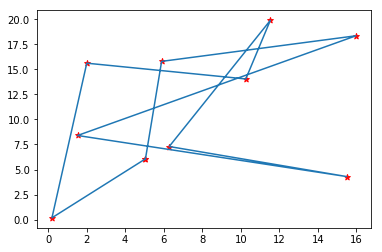

In [34]:
points = random_cluster(10)
plot_tour(points + points[:1])
res, costs = sim_anneal(points, change_arbitrary)
res.append(res[0])

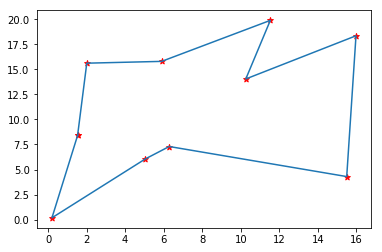

In [35]:
plot_tour(res)

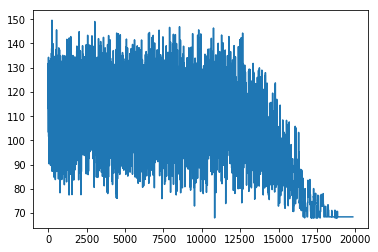

In [36]:
plot_tour_distances(costs)

Jak można zauważyć na powyższym wykresie - początkowa temperatura została źle dobrana - koszt na początku przez dużą liczbę iteracji skacze pomiędzy wartościami

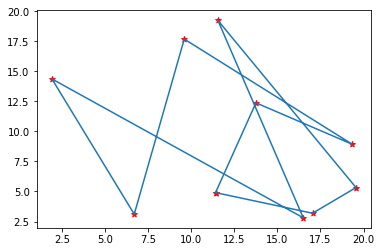

In [37]:
points = random_cluster(10)
plot_tour(points + points[:1])
res, costs = sim_anneal(points, change_arbitrary, T=10)
res.append(res[0])

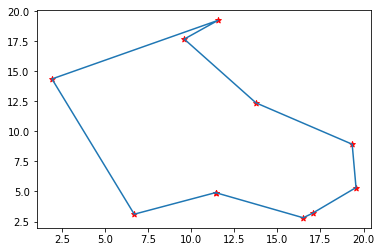

In [38]:
plot_tour(res)

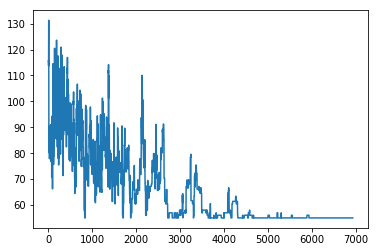

In [39]:
plot_tour_distances(costs)

powyższe spore wahania spowodowane są dużymi różnicami kosztów pomiędzy dowolną zmianą trasy 

#### change_consecutive function:

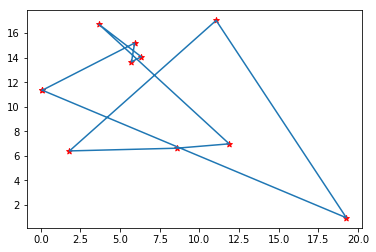

In [42]:
points = random_cluster(10)
plot_tour(points + points[:1])
res, costs = sim_anneal(points, change_consecutive, T=10)
res.append(res[0])

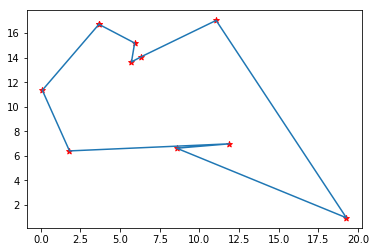

In [43]:
plot_tour(res)

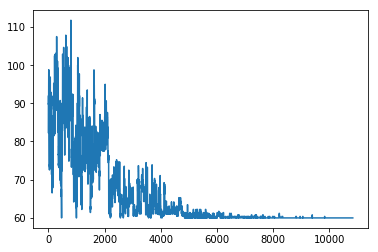

In [44]:
plot_tour_distances(costs)

#### inverse function:

In [46]:
points = random_cluster(10)
res, costs = sim_anneal(points, inverse, T=100)
res.append(res[0])

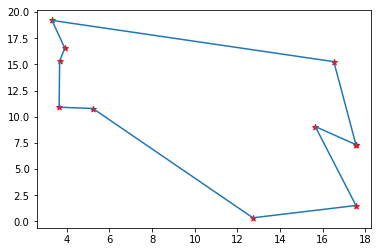

In [47]:
plot_tour(res)

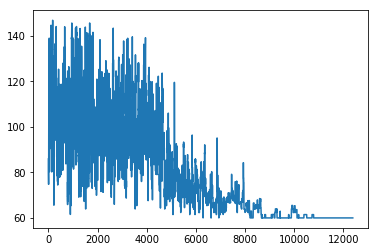

In [48]:
plot_tour_distances(costs)

Jak można zauważyć, różnica, pomiędzy bezpośrednią zamianą a zamianą krawędzi przy niewielkiej liczbie punktów nie ma dużego znaczenia

### 100 losowych punktów:

#### change_arbitrary function:

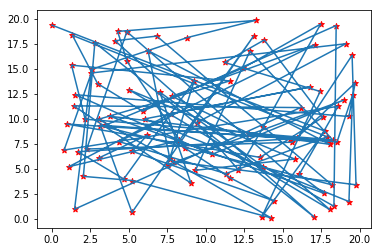

In [49]:
points = random_cluster(100)
plot_tour(points)
res, costs = sim_anneal(points, change_arbitrary, temp_fun=(lambda x: x * 0.9998), T=1000, min_temp=1e-7)
res.append(res[0])

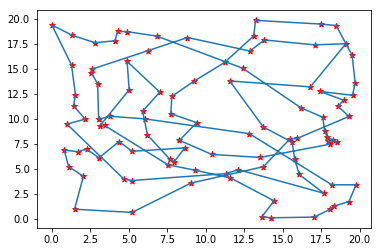

In [50]:
plot_tour(res)

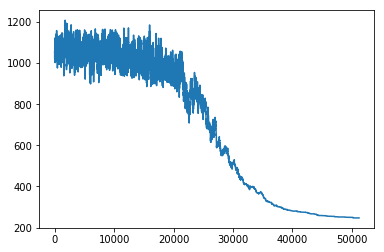

In [51]:
plot_tour_distances(costs)

#### change_consecutive function:

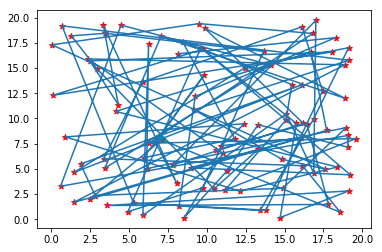

In [52]:
points = random_cluster(100)
plot_tour(points)
res, costs = sim_anneal(points, change_consecutive, temp_fun=(lambda x: x * 0.9998), T=1000, min_temp=1e-7)
res.append(res[0])

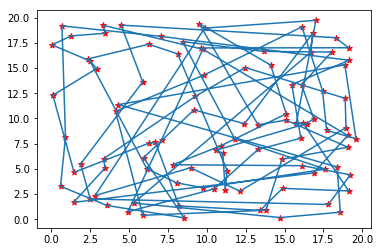

In [53]:
plot_tour(res)

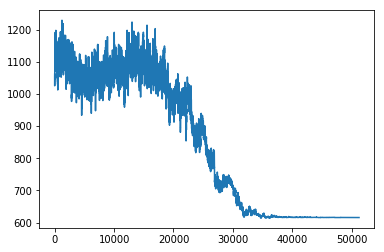

In [54]:
plot_tour_distances(costs)

#### Inverse function:

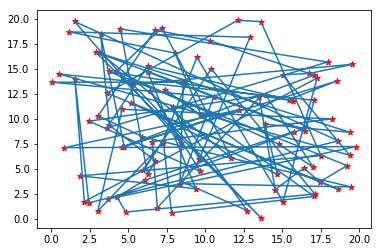

In [58]:
points = random_cluster(100)
plot_tour(points)
res, costs = sim_anneal(points, inverse, temp_fun=(lambda x: x * 0.9998), T=1000, min_temp=1e-7)
res.append(res[0])

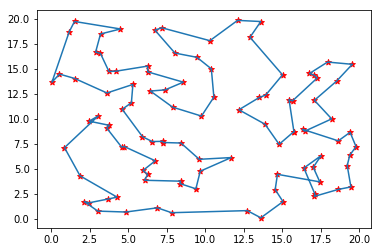

In [59]:
plot_tour(res)

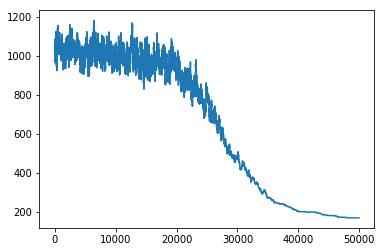

In [60]:
plot_tour_distances(costs)

### 40 losowych punktów:

#### change_arbitrary function

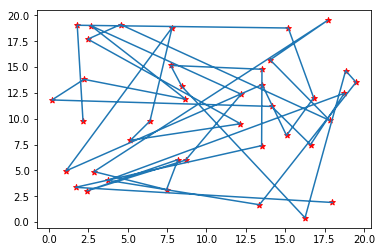

In [61]:
points = random_cluster(40)
plot_tour(points)
res, costs = sim_anneal(points, change_arbitrary, temp_fun=(lambda x: x * 0.9998), T=50, min_temp=1e-5)
res.append(res[0])

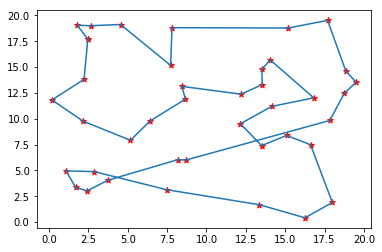

In [62]:
plot_tour(res)

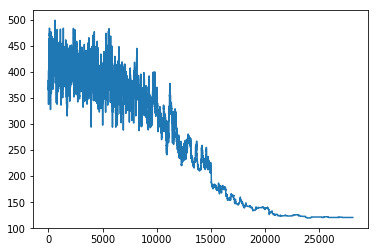

In [63]:
plot_tour_distances(costs)

#### change_consecutive function:

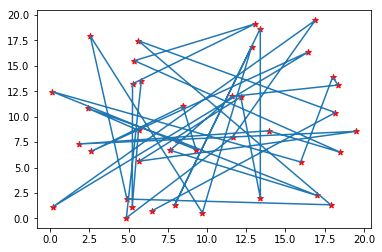

In [64]:
points = random_cluster(40)
plot_tour(points)
res, costs = sim_anneal(points, change_consecutive, temp_fun=(lambda x: x * 0.9998), T=50, min_temp=1e-5)
res.append(res[0])

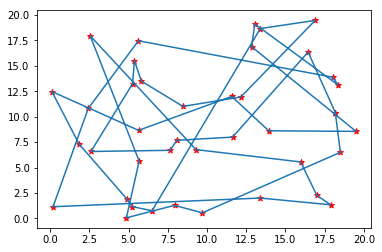

In [65]:
plot_tour(res)

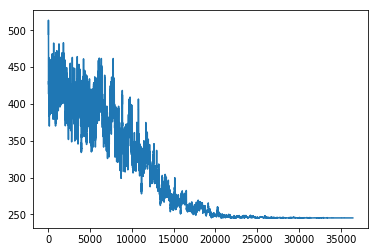

In [66]:
plot_tour_distances(costs)

#### inverse function:

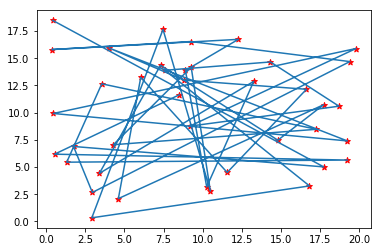

In [73]:
points = random_cluster(40)
plot_tour(points)
res, costs = sim_anneal(points, inverse, temp_fun=(lambda x: x * 0.9998), T=50, min_temp=1e-5)
res.append(res[0])

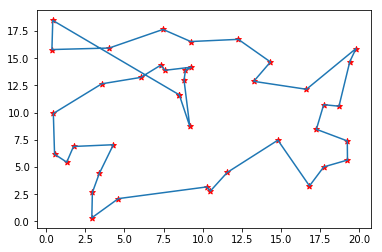

In [74]:
plot_tour(res)

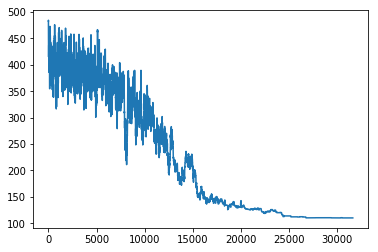

In [75]:
plot_tour_distances(costs)

### 4 klastry po 10 elementów:

#### change_arbitrary function:

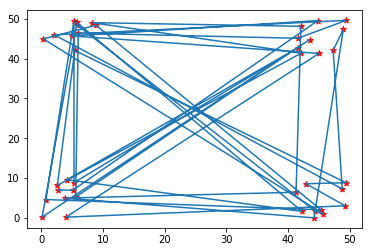

In [77]:
points = cluster_4_subclasters(40)
plot_tour(points)
res, costs = sim_anneal(points, change_arbitrary, temp_fun=(lambda x: x * 0.995), T=1000, min_temp=1e-7)
res.append(res[0])

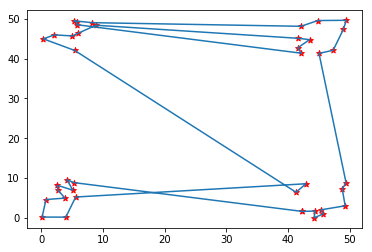

In [78]:
plot_tour(res)

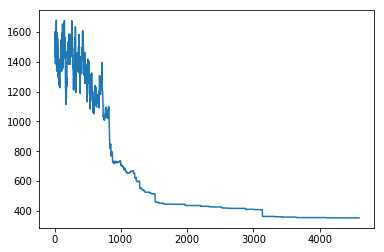

In [79]:
plot_tour_distances(costs)

#### change_consecutive function:

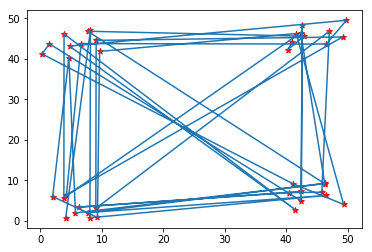

In [80]:
points = cluster_4_subclasters(40)
plot_tour(points)
res, costs = sim_anneal(points, change_consecutive, temp_fun=(lambda x: x * 0.995), T=1000, min_temp=1e-7)
res.append(res[0])

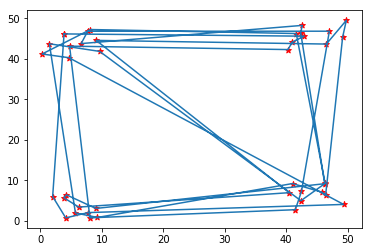

In [81]:
plot_tour(res)

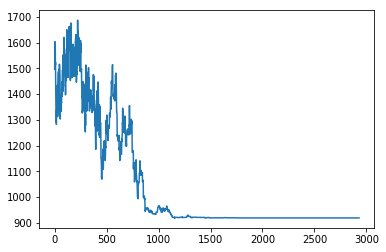

In [82]:
plot_tour_distances(costs)

#### inverse function

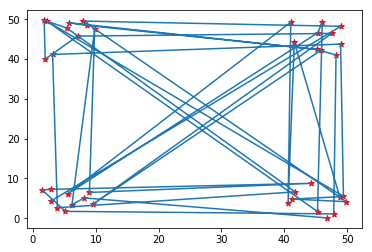

In [86]:
points = cluster_4_subclasters(40)
plot_tour(points)
res, costs = sim_anneal(points, inverse, temp_fun=(lambda x: x * 0.995), T=1000, min_temp=1e-7)
res.append(res[0])

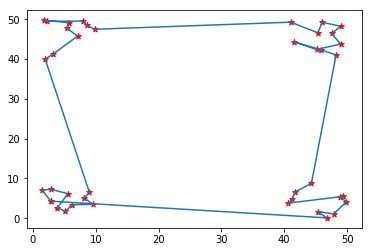

In [87]:
plot_tour(res)

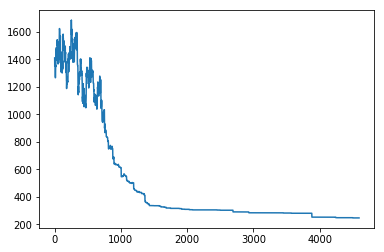

In [88]:
plot_tour_distances(costs)

### 4 klastry po 20 elementów:

#### change_arbitrary function

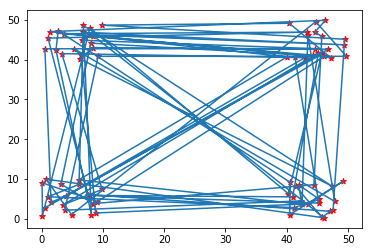

In [89]:
points = cluster_4_subclasters(80)
plot_tour(points)
res, costs = sim_anneal(points, change_arbitrary, temp_fun=(lambda x: x * 0.9998), T=500, min_temp=1e-7)
res.append(res[0])

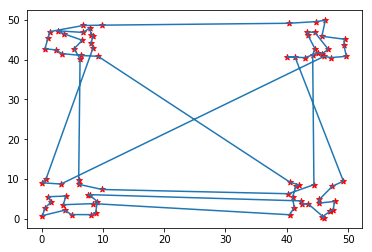

In [90]:
plot_tour(res)

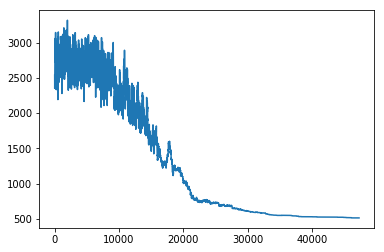

In [91]:
plot_tour_distances(costs)

#### change_consecutive function

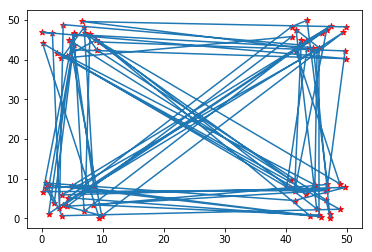

In [92]:
points = cluster_4_subclasters(80)
plot_tour(points)
res, costs = sim_anneal(points, change_consecutive, temp_fun=(lambda x: x * 0.9998), T=500, min_temp=1e-7)
res.append(res[0])

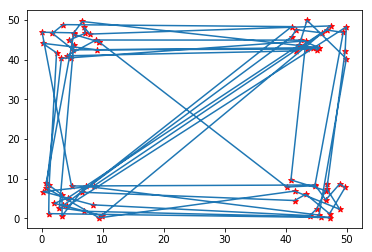

In [93]:
plot_tour(res)

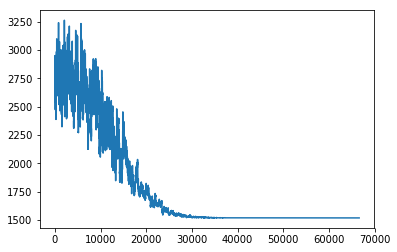

In [94]:
plot_tour_distances(costs)

#### inverse function

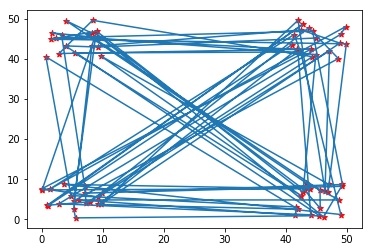

In [96]:
points = cluster_4_subclasters(80)
plot_tour(points)
res, costs = sim_anneal(points, inverse, temp_fun=(lambda x: x * 0.9998), T=500, min_temp=1e-7)
res.append(res[0])

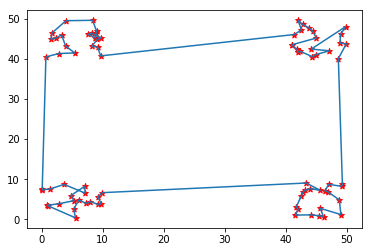

In [97]:
plot_tour(res)

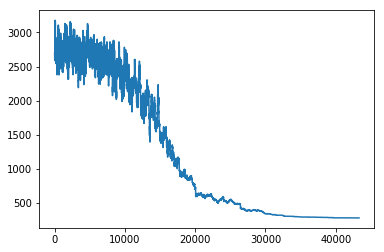

In [98]:
plot_tour_distances(costs)

### 9 klastrów po 10 elementów:

#### change_arbitrary function

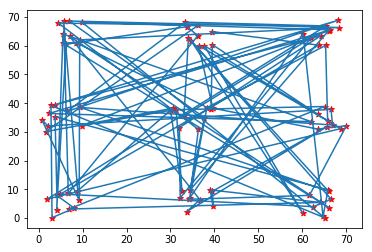

In [117]:
points = cluster_9_subclusters(90)
plot_tour(points)
res, costs = sim_anneal(points, change_arbitrary, temp_fun=(lambda x: x * 0.99985), T=1000, min_temp=1e-9)
res.append(res[0])

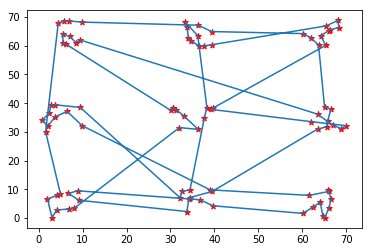

In [118]:
plot_tour(res)

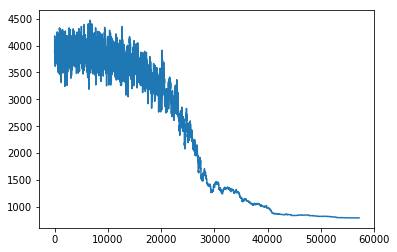

In [119]:
plot_tour_distances(costs)

#### change_consecutive function

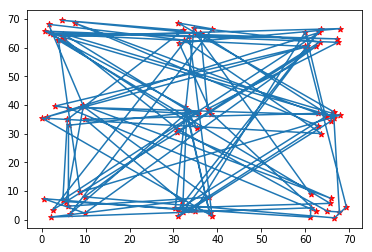

In [114]:
points = cluster_9_subclusters(90)
plot_tour(points)
res, costs = sim_anneal(points, change_consecutive, temp_fun=(lambda x: x * 0.9998), T=1000, min_temp=1e-9)
res.append(res[0])

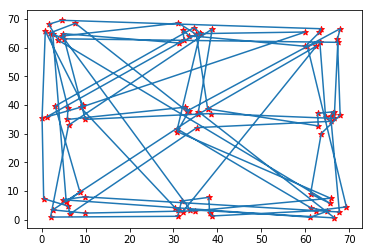

In [115]:
plot_tour(res)

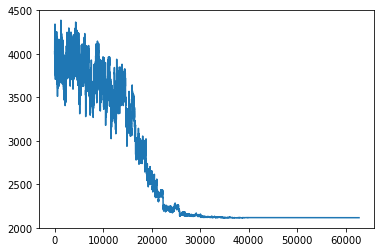

In [116]:
plot_tour_distances(costs)

#### inverse function

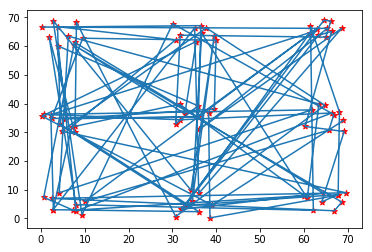

In [111]:
points = cluster_9_subclusters(90)
plot_tour(points)
res, costs = sim_anneal(points, inverse, temp_fun=(lambda x: x * 0.9998), T=100, min_temp=1e-7)
res.append(res[0])

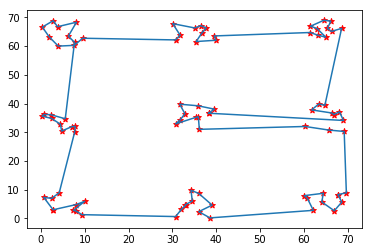

In [112]:
plot_tour(res)

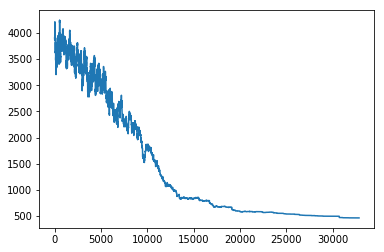

In [113]:
plot_tour_distances(costs)

# Podsumowanie
----
Jak można zauważyć dla małej ilości punktów różnica pomiędzy arbitrary swap, a consecutive swap jest niezauważalna, jednak przy większej ilości punktów lub nie regularnym rozłożeniu punktów (4 lub 9 klastrów) zachowuje się znaczeni lepiej, choć i tak zdecydowanie najlepsze właściwości posiada funkcja zamiany ścieżek, co można łatwo zauważyć na przedstawionych powyżej obrazach